In [36]:
import os
import pandas as pd
import numpy as np
from census import Census
from us import states
import requests
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
pip install census requests us

In [5]:
# Census API key
plt.rcParams["figure.figsize"] = (8, 4)

# --- keys & constants ---
CENSUS_API_KEY = "ce8b9610a02a2db4fd9e5ccb0412895621293667"
c = Census(CENSUS_API_KEY)

In [6]:

STATE_FIPS = states.CA.fips          # '06'
SAN_DIEGO_COUNTY_FIPS = "073"        # San Diego County
START_YEAR = 2018
END_YEAR = 2023

# folder for any local CSVs you download
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

In [7]:
ACS_VARS = {
    "B01003_001E": "pop_total",
    "B19013_001E": "med_income",
    "B01002_001E": "med_age",
    "B02001_002E": "white_alone",
    "B02001_003E": "black_alone",
    "B02001_005E": "asian_alone",
    "B03002_012E": "hispanic_any",
    "B17001_002E": "pop_below_poverty",
}

acs_cols = tuple(ACS_VARS.keys()) + ("NAME",)

tracts_raw = c.acs5.state_county_tract(
    acs_cols,
    STATE_FIPS,
    SAN_DIEGO_COUNTY_FIPS,
    Census.ALL
)

acs = pd.DataFrame(tracts_raw)
acs.rename(columns=ACS_VARS, inplace=True)

# construct full GEOID
acs["GEOID"] = acs["state"] + acs["county"] + acs["tract"]

# some handy fractions
acs["p_white"] = acs["white_alone"] / acs["pop_total"]
acs["p_black"] = acs["black_alone"] / acs["pop_total"]
acs["p_asian"] = acs["asian_alone"] / acs["pop_total"]
acs["p_hispanic"] = acs["hispanic_any"] / acs["pop_total"]
acs["p_poverty"] = acs["pop_below_poverty"] / acs["pop_total"]

acs.head()

,pop_total,med_income,med_age,white_alone,black_alone,asian_alone,hispanic_any,pop_below_poverty,NAME,state,county,tract,GEOID,p_white,p_black,p_asian,p_hispanic,p_poverty
0,2746.0,211023.0,52.5,2282.0,36.0,136.0,300.0,46.0,Census Tract 1; San Diego County; California,06,073,000100,06073000100,0.831027,0.013110,0.049527,0.109250,0.016752
1,2376.0,110476.0,49.9,2082.0,0.0,136.0,82.0,210.0,Census Tract 2.01; San Diego County; California,06,073,000201,06073000201,0.876263,0.000000,0.057239,0.034512,0.088384
2,4019.0,121264.0,41.9,3297.0,29.0,184.0,769.0,158.0,Census Tract 2.02; San Diego County; California,06,073,000202,06073000202,0.820353,0.007216,0.045783,0.191341,0.039313
3,2487.0,79605.0,39.6,1771.0,22.0,131.0,531.0,386.0,Census Tract 3.01; San Diego County; California,06,073,000301,06073000301,0.712103,0.008846,0.052674,0.213510,0.155207
4,2925.0,89850.0,44.0,2135.0,113.0,188.0,554.0,277.0,Census Tract 3.02; San Diego County; California,06,073,000302,06073000302,0.729915,0.038632,0.064274,0.189402,0.094701


In [8]:
# Classify tracts as coastal or inland based on distance from tract centroids to the coast

def get_tract_centroids(state_fips="06", county_fips="073"):
    layer = 10  # Census Tracts layer
    url = (
        f"https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Tracts_Blocks/MapServer/{layer}/query"
        f"?where=STATE+%3D+'{state_fips}'+AND+COUNTY+%3D+'{county_fips}'"
        f"&outFields=STATE,COUNTY,TRACT"
        f"&returnGeometry=true&geometryPrecision=6&outSR=4326"
        f"&f=json"
    )

    resp = requests.get(url).json()

    if "features" not in resp:
        print("API returned an error:", resp)
        raise ValueError("TIGERweb query failed")

    rows = []

    for feat in resp["features"]:
        attrs = feat["attributes"]
        geom = feat["geometry"]["rings"][0]

        xs = [p[0] for p in geom]
        ys = [p[1] for p in geom]
        lon = sum(xs) / len(xs)
        lat = sum(ys) / len(ys)

        rows.append({
            "STATE": attrs["STATE"],
            "COUNTY": attrs["COUNTY"],
            "TRACT": attrs["TRACT"],
            "centroid_lon": lon,
            "centroid_lat": lat
        })

    return pd.DataFrame(rows)

centroids = get_tract_centroids()
centroids["GEOID"] = centroids["STATE"] + centroids["COUNTY"] + centroids["TRACT"]




In [9]:
acs = acs.merge(centroids, on="GEOID", how="left")

acs["region"] = acs["centroid_lon"].apply(
    lambda x: "coastal" if x > -117.25 else "inland"
)

acs["region"].value_counts()

region
coastal    631
inland     106
Name: count, dtype: int64

In [10]:
acs.isnull().sum().sum()

10

In [11]:
acs

,pop_total,med_income,med_age,white_alone,black_alone,asian_alone,hispanic_any,pop_below_poverty,NAME,state,...,p_black,p_asian,p_hispanic,p_poverty,STATE,COUNTY,TRACT,centroid_lon,centroid_lat,region
0,2746.0,211023.0,52.5,2282.0,36.0,136.0,300.0,46.0,Census Tract 1; San Diego County; California,06,...,0.013110,0.049527,0.109250,0.016752,06,073,000100,-117.187236,32.751905,coastal
1,2376.0,110476.0,49.9,2082.0,0.0,136.0,82.0,210.0,Census Tract 2.01; San Diego County; California,06,...,0.000000,0.057239,0.034512,0.088384,06,073,000201,-117.173262,32.752901,coastal
2,4019.0,121264.0,41.9,3297.0,29.0,184.0,769.0,158.0,Census Tract 2.02; San Diego County; California,06,...,0.007216,0.045783,0.191341,0.039313,06,073,000202,-117.174778,32.745022,coastal
3,2487.0,79605.0,39.6,1771.0,22.0,131.0,531.0,386.0,Census Tract 3.01; San Diego County; California,06,...,0.008846,0.052674,0.213510,0.155207,06,073,000301,-117.166019,32.745216,coastal
4,2925.0,89850.0,44.0,2135.0,113.0,188.0,554.0,277.0,Census Tract 3.02; San Diego County; California,06,...,0.038632,0.064274,0.189402,0.094701,06,073,000302,-117.159808,32.744429,coastal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,3089.0,42976.0,32.1,866.0,149.0,207.0,2376.0,607.0,Census Tract 219; San Diego County; California,06,...,0.048236,0.067012,0.769181,0.196504,06,073,021900,-117.109322,32.665954,coastal
733,4357.0,66801.0,38.2,1288.0,113.0,1347.0,2208.0,296.0,Census Tract 220; San Diego County; California,06,...,0.025935,0.309158,0.506771,0.067937,06,073,022000,-117.087276,32.679864,coastal
734,2279.0,156678.0,47.0,1686.0,29.0,189.0,77.0,65.0,Census Tract 221.01; San Diego County; California,06,...,0.012725,0.082931,0.033787,0.028521,06,073,022101,-117.297984,33.134058,inland
735,7322.0,143056.0,40.1,4334.0,147.0,885.0,1619.0,535.0,Census Tract 221.02; San Diego County; California,06,...,0.020076,0.120869,0.221114,0.073067,06,073,022102,-117.281820,33.112983,inland


## Basic EDA

In [12]:
acs.columns

Index(['pop_total', 'med_income', 'med_age', 'white_alone', 'black_alone',
       'asian_alone', 'hispanic_any', 'pop_below_poverty', 'NAME', 'state',
       'county', 'tract', 'GEOID', 'p_white', 'p_black', 'p_asian',
       'p_hispanic', 'p_poverty', 'STATE', 'COUNTY', 'TRACT', 'centroid_lon',
       'centroid_lat', 'region'],
      dtype='object')

In [13]:
acs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pop_total          737 non-null    float64
 1   med_income         737 non-null    float64
 2   med_age            737 non-null    float64
 3   white_alone        737 non-null    float64
 4   black_alone        737 non-null    float64
 5   asian_alone        737 non-null    float64
 6   hispanic_any       737 non-null    float64
 7   pop_below_poverty  737 non-null    float64
 8   NAME               737 non-null    object 
 9   state              737 non-null    object 
 10  county             737 non-null    object 
 11  tract              737 non-null    object 
 12  GEOID              737 non-null    object 
 13  p_white            735 non-null    float64
 14  p_black            735 non-null    float64
 15  p_asian            735 non-null    float64
 16  p_hispanic         735 non

In [16]:
acs.describe()

,pop_total,med_income,med_age,white_alone,black_alone,asian_alone,hispanic_any,pop_below_poverty,p_white,p_black,p_asian,p_hispanic,p_poverty,centroid_lon,centroid_lat
count,737.000000,7.370000e+02,7.370000e+02,737.000000,737.000000,737.000000,737.000000,737.000000,735.000000,735.000000,735.000000,735.000000,735.000000,737.000000,737.000000
mean,4454.249661,-7.126849e+06,-1.809097e+06,2361.221167,209.763908,544.175034,1529.472185,448.578019,0.544824,0.045894,0.115042,0.333832,0.100221,-117.113063,32.876123
std,2107.362836,6.913806e+07,3.470522e+07,1324.373218,290.434759,666.332208,1278.671273,383.925575,0.188517,0.055203,0.119664,0.221480,0.075277,0.130598,0.200816
min,0.000000,-6.666667e+08,-6.666667e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.072311,0.000000,0.000000,0.000000,0.000000,-117.389645,32.546651
25%,3313.000000,7.744400e+04,3.400000e+01,1586.000000,40.000000,134.000000,611.000000,174.000000,0.390616,0.009314,0.036115,0.158631,0.048073,-117.209949,32.725521
50%,4257.000000,1.036170e+05,3.840000e+01,2202.000000,107.000000,300.000000,1185.000000,338.000000,0.557272,0.027451,0.071991,0.272112,0.079747,-117.110025,32.808973
75%,5436.000000,1.343580e+05,4.270000e+01,2893.000000,269.000000,645.000000,2071.000000,603.000000,0.704600,0.061019,0.144099,0.477326,0.132184,-117.043736,33.038351
max,40481.000000,2.500010e+05,7.310000e+01,22239.000000,3760.000000,5653.000000,13887.000000,3370.000000,0.905005,0.440678,0.642278,0.959959,0.427508,-116.381106,33.412082


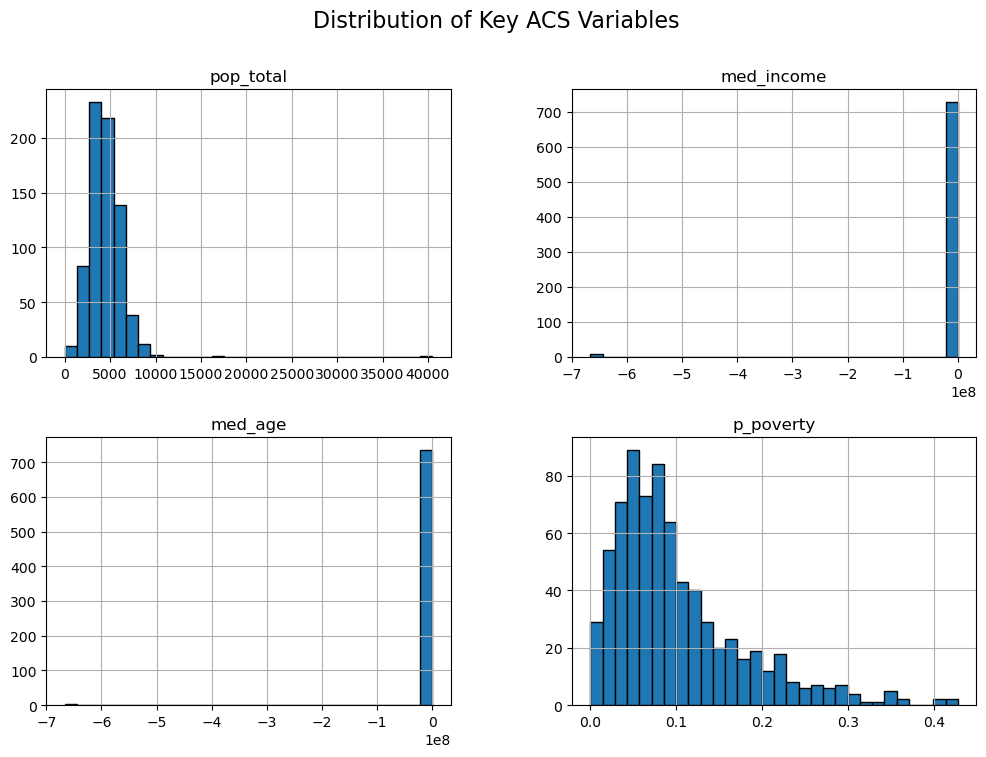

In [17]:
num_cols = ["pop_total", "med_income", "med_age", "p_poverty"]

acs[num_cols].hist(bins=30, figsize=(12, 8), edgecolor="black")
plt.suptitle("Distribution of Key ACS Variables", fontsize=16)
plt.show()


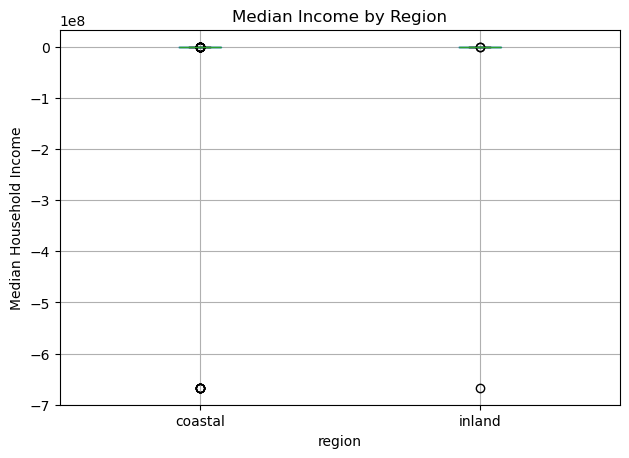

In [18]:
acs.boxplot(column="med_income", by="region", figsize=(7,5))
plt.title("Median Income by Region")
plt.suptitle("")
plt.ylabel("Median Household Income")
plt.show()

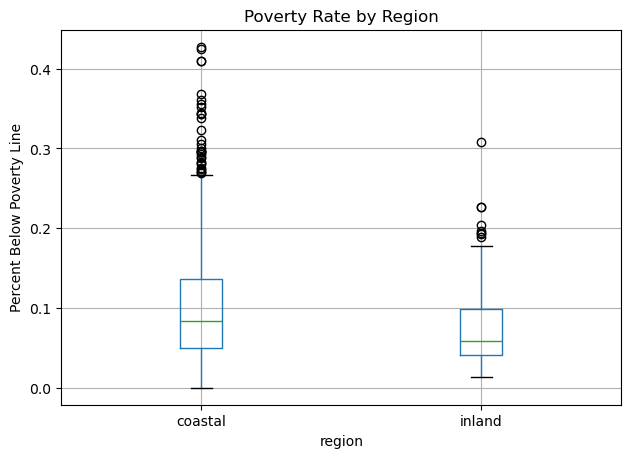

In [19]:
acs.boxplot(column="p_poverty", by="region", figsize=(7,5))
plt.title("Poverty Rate by Region")
plt.suptitle("")
plt.ylabel("Percent Below Poverty Line")
plt.show()

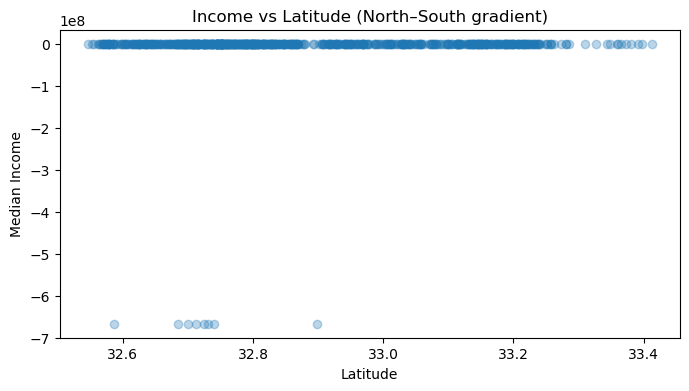

In [21]:
plt.scatter(acs["centroid_lat"], acs["med_income"], alpha=0.3)
plt.xlabel("Latitude")
plt.ylabel("Median Income")
plt.title("Income vs Latitude (North–South gradient)")
plt.show()


In [23]:
acs[(acs['med_income'] < 0) | (acs['med_age'] < 0)]

,pop_total,med_income,med_age,white_alone,black_alone,asian_alone,hispanic_any,pop_below_poverty,NAME,state,...,p_black,p_asian,p_hispanic,p_poverty,STATE,COUNTY,TRACT,centroid_lon,centroid_lat,region
90,8774.0,-666666666.0,24.8,4492.0,1621.0,1060.0,2034.0,0.0,Census Tract 38; San Diego County; California,06,...,0.184750,0.120811,0.231821,0.0,06,073,003800,-117.124220,32.685547,coastal
115,295.0,-666666666.0,20.9,119.0,130.0,0.0,57.0,0.0,Census Tract 55; San Diego County; California,06,...,0.440678,0.000000,0.193220,0.0,06,073,005500,-117.146953,32.724275,coastal
124,31.0,-666666666.0,20.5,16.0,7.0,0.0,0.0,0.0,Census Tract 62; San Diego County; California,06,...,0.225806,0.000000,0.000000,0.0,06,073,006200,-117.192883,32.730803,coastal
125,2490.0,-666666666.0,20.3,1542.0,221.0,141.0,880.0,0.0,Census Tract 63; San Diego County; California,06,...,0.088755,0.056627,0.353414,0.0,06,073,006300,-117.197218,32.739942,coastal
268,1462.0,-666666666.0,30.1,987.0,91.0,199.0,406.0,0.0,Census Tract 99.01; San Diego County; California,06,...,0.062244,0.136115,0.277702,0.0,06,073,009901,-117.245466,32.699636,coastal
269,0.0,-666666666.0,-666666666.0,0.0,0.0,0.0,0.0,0.0,Census Tract 99.02; San Diego County; California,06,...,NaN,NaN,NaN,NaN,06,073,009902,-117.212779,32.711843,coastal
280,3217.0,-666666666.0,41.6,1426.0,940.0,69.0,1417.0,0.0,Census Tract 100.16; San Diego County; California,06,...,0.292198,0.021449,0.440472,0.0,06,073,010016,-116.969576,32.586191,coastal
736,0.0,-666666666.0,-666666666.0,0.0,0.0,0.0,0.0,0.0,Census Tract 9901; San Diego County; California,06,...,NaN,NaN,NaN,NaN,06,073,990100,-117.310319,32.898249,inland


- While there are very few missing values, some tracts have too low of a population and/or its estimates for median income and median age were too unreliable, that's why a lot of these plots look so skewed, therefore the 8 rows above will be dropped.

In [25]:
bad_rows = acs[(acs['med_income'] < 0) | (acs['med_age'] < 0)]
acs = acs[~((acs['med_income'] < 0) | (acs['med_age'] < 0))].copy()


In [26]:
acs.describe()

,pop_total,med_income,med_age,white_alone,black_alone,asian_alone,hispanic_any,pop_below_poverty,p_white,p_black,p_asian,p_hispanic,p_poverty,centroid_lon,centroid_lat
count,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000
mean,4480.813443,110899.813443,38.995885,2375.360768,207.936900,548.131687,1539.680384,453.500686,0.544961,0.044496,0.115529,0.334526,0.101046,-117.112384,32.877814
std,2082.929523,43742.453936,7.150089,1316.171214,285.660876,667.961366,1279.673597,383.122847,0.189093,0.051955,0.119932,0.221906,0.075032,0.130779,0.201085
min,889.000000,24125.000000,17.100000,240.000000,0.000000,0.000000,46.000000,0.000000,0.072311,0.000000,0.000000,0.021289,0.000000,-117.389645,32.546651
25%,3319.000000,78516.000000,34.100000,1596.000000,40.000000,135.000000,623.000000,184.000000,0.388759,0.009199,0.036488,0.158531,0.048909,-117.208351,32.727548
50%,4273.000000,104457.000000,38.500000,2208.000000,107.000000,305.000000,1187.000000,342.000000,0.557307,0.026870,0.072070,0.272112,0.080158,-117.108433,32.811934
75%,5442.000000,135000.000000,42.700000,2909.000000,269.000000,647.000000,2083.000000,606.000000,0.706202,0.060272,0.144307,0.480417,0.134254,-117.043326,33.040676
max,40481.000000,250001.000000,73.100000,22239.000000,3760.000000,5653.000000,13887.000000,3370.000000,0.905005,0.283006,0.642278,0.959959,0.427508,-116.381106,33.412082


In [27]:
acs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 729 entries, 0 to 735
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pop_total          729 non-null    float64
 1   med_income         729 non-null    float64
 2   med_age            729 non-null    float64
 3   white_alone        729 non-null    float64
 4   black_alone        729 non-null    float64
 5   asian_alone        729 non-null    float64
 6   hispanic_any       729 non-null    float64
 7   pop_below_poverty  729 non-null    float64
 8   NAME               729 non-null    object 
 9   state              729 non-null    object 
 10  county             729 non-null    object 
 11  tract              729 non-null    object 
 12  GEOID              729 non-null    object 
 13  p_white            729 non-null    float64
 14  p_black            729 non-null    float64
 15  p_asian            729 non-null    float64
 16  p_hispanic         729 non-null

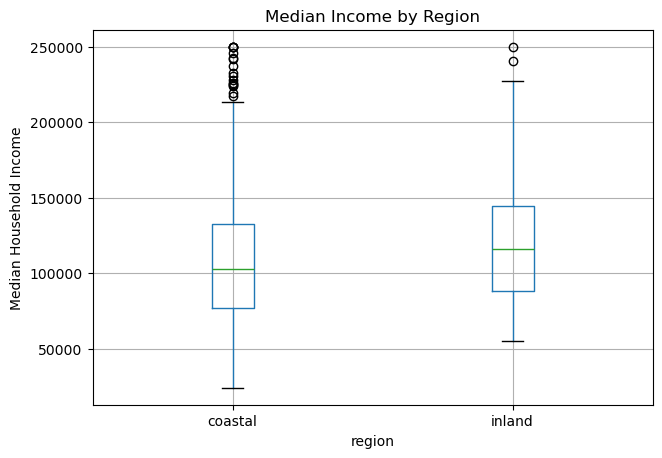

In [28]:
acs.boxplot(column="med_income", by="region", figsize=(7,5))
plt.title("Median Income by Region")
plt.suptitle("")
plt.ylabel("Median Household Income")
plt.show()

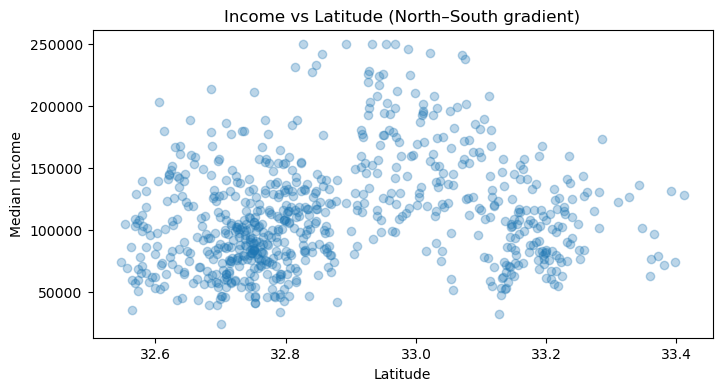

In [29]:
plt.scatter(acs["centroid_lat"], acs["med_income"], alpha=0.3)
plt.xlabel("Latitude")
plt.ylabel("Median Income")
plt.title("Income vs Latitude (North–South gradient)")
plt.show()

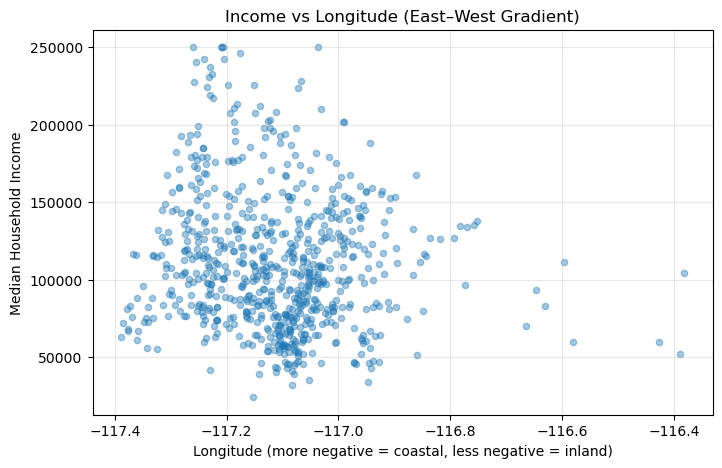

In [30]:
plt.figure(figsize=(8, 5))

plt.scatter(
    acs["centroid_lon"],
    acs["med_income"],
    alpha=0.4,
    s=20
)

plt.xlabel("Longitude (more negative = coastal, less negative = inland)")
plt.ylabel("Median Household Income")
plt.title("Income vs Longitude (East–West Gradient)")

plt.grid(True, alpha=0.3)
plt.show()


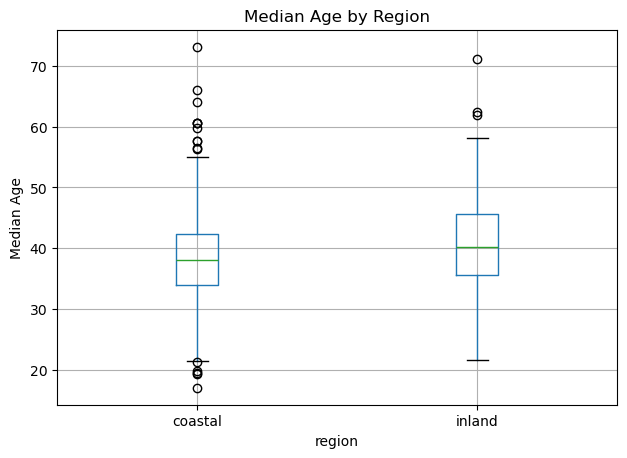

In [31]:
acs.boxplot(column="med_age", by="region", figsize=(7,5))
plt.title("Median Age by Region")
plt.suptitle("")
plt.ylabel("Median Age")
plt.show()

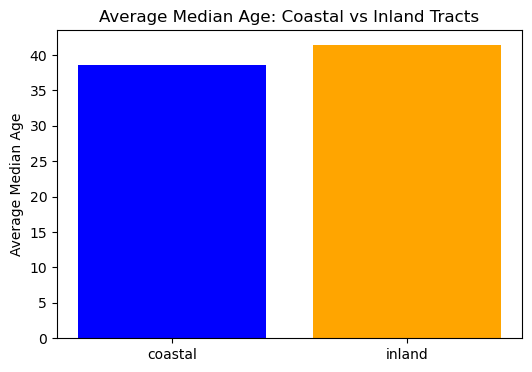

In [32]:
avg_age = acs.groupby("region")["med_age"].mean().reset_index()

plt.figure(figsize=(6,4))
plt.bar(avg_age["region"], avg_age["med_age"], color=["blue", "orange"])
plt.ylabel("Average Median Age")
plt.title("Average Median Age: Coastal vs Inland Tracts")
plt.show()

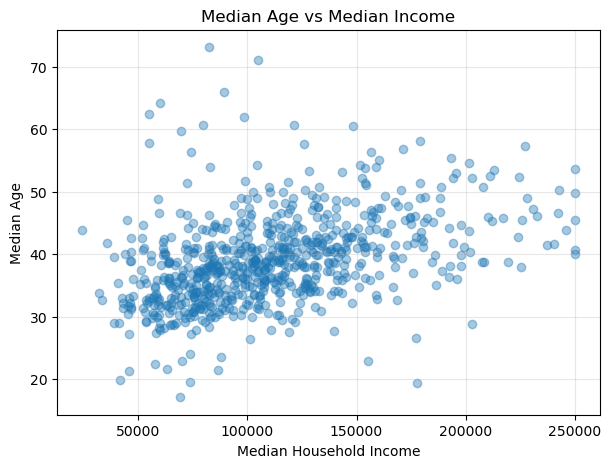

In [33]:
plt.figure(figsize=(7,5))
plt.scatter(acs["med_income"], acs["med_age"], alpha=0.4)
plt.xlabel("Median Household Income")
plt.ylabel("Median Age")
plt.title("Median Age vs Median Income")
plt.grid(alpha=0.3)
plt.show()


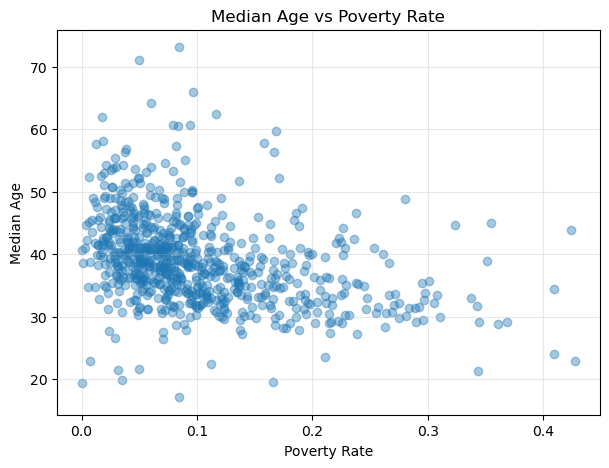

In [34]:
plt.figure(figsize=(7,5))
plt.scatter(acs["p_poverty"], acs["med_age"], alpha=0.4)
plt.xlabel("Poverty Rate")
plt.ylabel("Median Age")
plt.title("Median Age vs Poverty Rate")
plt.grid(alpha=0.3)
plt.show()


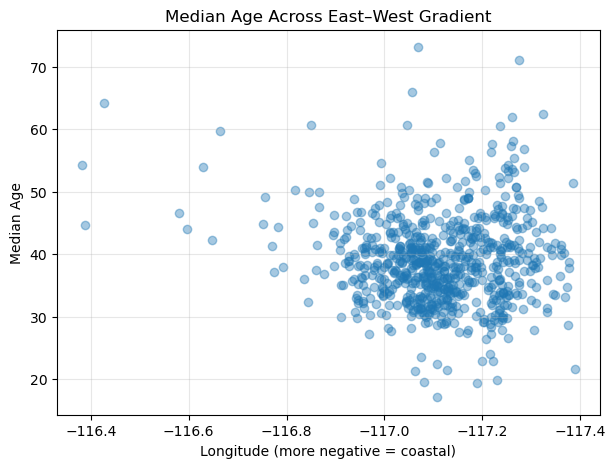

In [35]:
plt.figure(figsize=(7,5))
plt.scatter(acs["centroid_lon"], acs["med_age"], alpha=0.4)
plt.xlabel("Longitude (more negative = coastal)")
plt.ylabel("Median Age")
plt.title("Median Age Across East–West Gradient")
plt.grid(alpha=0.3)
plt.gca().invert_xaxis()  # makes coastline appear on the left
plt.show()


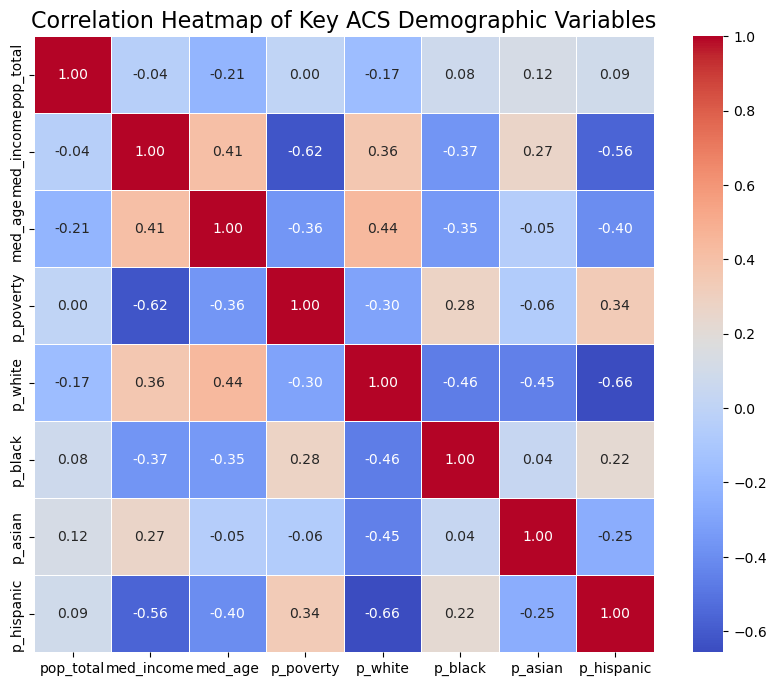

In [37]:
corr_cols = [
    "pop_total",
    "med_income",
    "med_age",
    "p_poverty",
    "p_white",
    "p_black",
    "p_asian",
    "p_hispanic"
]

# Compute correlation matrix
corr_matrix = acs[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f", 
    linewidths=0.5
)
plt.title("Correlation Heatmap of Key ACS Demographic Variables", fontsize=16)
plt.show()

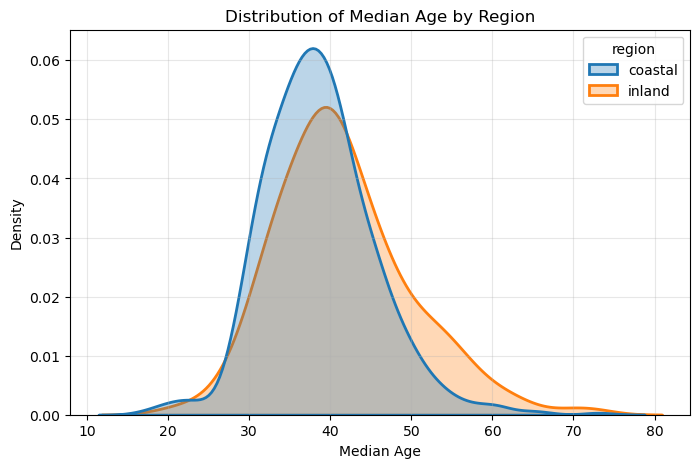

In [39]:
plt.figure(figsize=(8, 5))

sns.kdeplot(
    data=acs,
    x="med_age",
    hue="region",
    fill=True,
    common_norm=False,
    alpha=0.3,
    linewidth=2
)

plt.title("Distribution of Median Age by Region")
plt.xlabel("Median Age")
plt.ylabel("Density")
plt.grid(alpha=0.3)
plt.show()

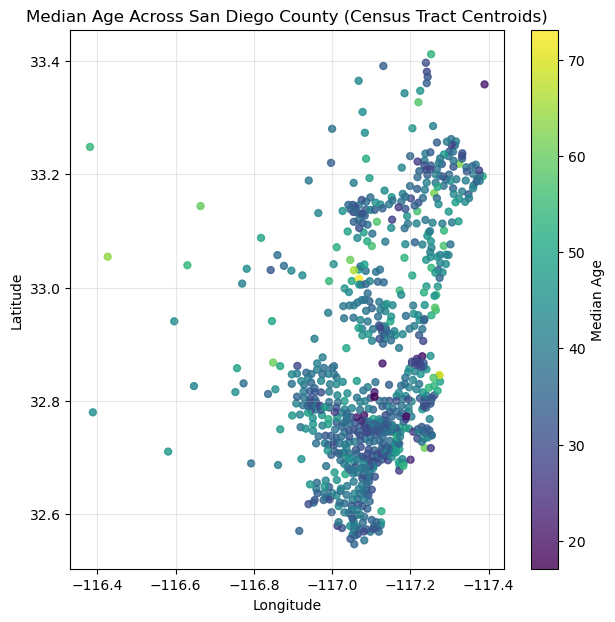

In [40]:
plt.figure(figsize=(7, 7))

# Use color to represent age
scatter = plt.scatter(
    acs["centroid_lon"],
    acs["centroid_lat"],
    c=acs["med_age"],
    cmap="viridis",
    s=25,
    alpha=0.8
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Median Age Across San Diego County (Census Tract Centroids)")
plt.gca().invert_xaxis()  # West (coast) on the left

# Colorbar legend
cbar = plt.colorbar(scatter)
cbar.set_label("Median Age")

plt.grid(alpha=0.3)
plt.show()
